In [1]:
!pip install paddlehelix
# import sys 
# sys.path.append('/home/aistudio/external-libraries')

Looking in indexes: https://mirror.baidu.com/pypi/simple/
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


### Data statistic

In [2]:
# 读取训练集、验证集和测试集数据
from utils import ReadData, ReadFasta, List2Dict, TRAIN_TXT, DEV_TXT, TEST_TXT, FOLDC_FEATURE_FILE, CONTRAFOLD_FEATURE_FILES

train_datas = ReadData(TRAIN_TXT, True)
print(len(train_datas))
dev_datas = ReadData(DEV_TXT, True)
print(len(dev_datas))
test_datas = ReadData(TEST_TXT, False)
print(len(test_datas))


4750
250
112


length: 100 861


(array([263., 194., 150., 135., 145., 105., 156., 215., 222., 241., 208.,
        170., 153., 159., 143., 141., 157., 177., 236., 208., 181., 222.,
        244., 248., 264., 251.,  90.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   6.,   0.,   0.,  22.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   0.,   3.]),
 array([100.  , 115.22, 130.44, 145.66, 160.88, 176.1 , 191.32, 206.54,
        221.76, 236.98, 252.2 , 267.42, 282.64, 297.86, 313.08, 328.3 ,
        343.52, 358.74, 373.96, 389.18, 404.4 , 419.62, 434.84, 450.06,
        465.28, 480.5 , 495.72, 510.94, 526.16, 541.38, 556.6 , 571.82,
        587.04, 602.26, 617.48, 632.7 , 647.92, 663.14, 678.36, 693.58,
        708.8 , 724.02, 739.24, 754.46, 769.68, 784.9 , 800.12, 815.34,
        830.56, 845.78, 861.  ]),
 <a list of 50 Patch objects>)

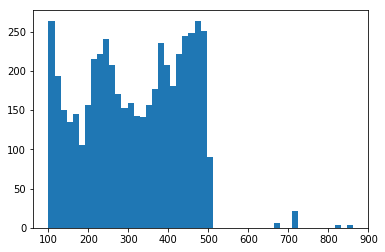

In [3]:
import os
import sys
import time
from tqdm import tqdm
# import numba
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pahelix.toolkit.linear_rna as linear_rna

np.random.seed(2021)

# 对rna长度和碱基分布进行统计分析
all_seq = []
all_stru = []
all_length = []
all_prob = []
prob_dict = {
    'A':[],
    'C':[],
    'G':[],
    'U':[],
    '(':[],
    ')':[],
    '.':[],
}
for data in train_datas+dev_datas+test_datas:
    all_seq+=data[1]
    all_stru += data[2]
    all_length += [len(data[1]),]
    if len(data)>3:
        all_prob+=data[3]
        for s,d,p in zip(data[1], data[2], data[3]):
            prob_dict[s].append(p)
            prob_dict[d].append(p)
print('length:', min(all_length), max(all_length))
plt.hist(all_length, bins=50)

In [4]:
# 碱基比例分布和结构比例分布
for k, v in prob_dict.items():
    print(k, sum(v)/len(v))
# plt.figure(), plt.hist(prob_dict['A'])
# plt.figure(), plt.hist(prob_dict['C'])
# plt.figure(), plt.hist(prob_dict['G'])
# plt.figure(), plt.hist(prob_dict['U'])
# plt.figure(), plt.hist(prob_dict['('])
# plt.figure(), plt.hist(prob_dict[')'])
# plt.figure(), plt.hist(prob_dict['.'])


A 0.6285336177922761
C 0.28163276316208524
G 0.3009997370205152
U 0.3637796560772179
( 0.14009909802542647
) 0.1424230962719017
. 0.8058003383427836


Counter({'G': 469293, 'A': 423831, 'U': 362568, 'C': 356323})
Counter({'.': 619535, '(': 496240, ')': 496240})


(array([819693.,  51007.,  29374.,  23551.,  21622.,  20957.,  22012.,
         29433.,  48337., 496750.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

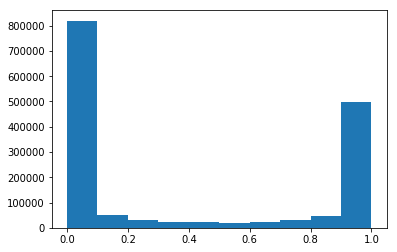

In [5]:
# 对训练集标签分布进行直方图分析
from collections import Counter
seq_cnt = Counter(all_seq)
stru_cnt = Counter(all_stru)
print(seq_cnt)
print(stru_cnt)
# print('prob:', min(all_prob), max(all_prob), all_prob[:20])
plt.hist(all_prob)

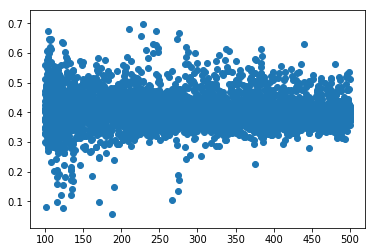

In [6]:
# 分析rna长度和平均不成对概率之间的关系
X = []
Y = []
for data in train_datas+dev_datas:
    X.append(len(data[1]))
    Y.append(sum(data[3])/len(data[3]))
X = np.array(X)
Y = np.array(Y)
idx = np.argsort(X)
X = X[idx]
Y = Y[idx]
plt.scatter(X, Y)

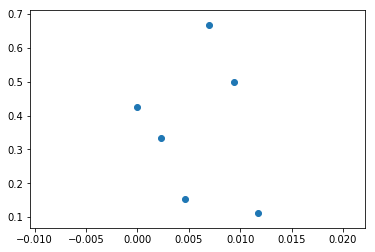

In [7]:
# 考察局部匹配特征和不成对概率之间的关联。发现该特征效果不好，后舍弃。
from MatchSub import CountMatch

data_i=0
seq = train_datas[data_i][1]
cnt = CountMatch(seq, 7)
prob = train_datas[data_i][3]
st={}
for c in cnt:
    st[c]=[]
for c, p in zip(cnt, prob):
    st[c].append(p)
x=[]
y=[]
for k, v in st.items():
    x.append(k)
    y.append(sum(v)/len(v))
    # print(k, sum(v)/len(v))
plt.scatter(x, y)


### Data Preprocess

In [8]:

# 训练数据填充长度
TRAIN_LENGTH = 768
# 测试数据填充长度
PREDICT_LENGTH = 5120
# 头部填充长度
PRE_FILL = 128
# 数据类型
DTYPE = np.float32

# 是否使用原始序列编码特征
USE_SEQ = True
# 是否使用结构序列编码特征
USE_DOT = True
# 是否使用foldc结构特征
USE_FOLD_C = True
# 是否使用contrafold结构特征
USE_CONTRAFOLD = True
# 不使用平均概率特征
USE_MEAN_PROB = False
# 不使用局部匹配特征
MATCH_NEIGHBORS = []

if USE_FOLD_C:
    # 读取预处理的foldc结构序列
    data = List2Dict(ReadFasta(FOLDC_FEATURE_FILE, with_structure=True))
    fold_c_features = {}
    for sid, val in data.items():
        fold_c_features[sid] = val[2]

if USE_CONTRAFOLD:
    # 读取预处理的contrafold结构序列
    contrafold_features = []
    for f in CONTRAFOLD_FEATURE_FILES:
        data = List2Dict(ReadFasta(f, with_structure=True))
        feature = {}
        for sid, val in data.items():
            feature[sid]=val[2]
        contrafold_features.append(feature)

# 计算A、C、G、U的平均概率，未使用该特征
PROB_DICT = {}
for k, v in prob_dict.items():
    PROB_DICT[k]=sum(v)/len(v)

# 对序列进行one hot编码，编码字典为coder
def Codec(seq, fill_length = TRAIN_LENGTH, pre_fill = PRE_FILL, coder={'A':0, 'C':1, 'G':2, 'U':3}):
    l = len(seq)
    feature = np.zeros([len(coder), fill_length], dtype=DTYPE)
    for i in range(l):
        feature[coder[seq[i]], pre_fill+i]=1.
    return feature

# 将序列填充到指定长度，序列头部填充指定长度的零
def Fill(feature, fill_length = TRAIN_LENGTH, pre_fill = PRE_FILL):
    if len(feature.shape)==1:
        feature = feature.reshape([1, -1])
    D = feature.shape[0]
    feature = feature.reshape([D, -1])
    L = feature.shape[1]
    filled = np.zeros([D, fill_length], dtype=DTYPE)
    filled[:, pre_fill:(pre_fill+L)] = feature
    return filled

# 将ACGU序列转换为对应的平均概率序列
def MeanProbFeature(seq, fill_length = TRAIN_LENGTH, pre_fill = PRE_FILL, dt=PROB_DICT):
    l = len(seq)
    feature = np.zeros([1, fill_length], dtype=DTYPE)
    for i in range(l):
        feature[0, pre_fill+i]=dt[seq[i]]
    return feature


In [9]:
def preprocess(data, fill_length = TRAIN_LENGTH, pre_fill = PRE_FILL):
    ## 按预定义参数把RNA序列转换为特征序列。本方法用到的都是one hot编码的特征。
    ## 返回值中的data[0]为序列名，feature为转换后的特征，l为原始序列长度，mask为填充的掩码，对训练集多返回一个prob为标签。
    coder = {'A':0, 'C':1, 'G':2, 'U':3, '.':0, '(':1, ')':2}
    l = len(data[1])
    mask = np.zeros([fill_length], dtype=DTYPE)
    mask[pre_fill:(l+pre_fill)]=1.
    features = []
    if USE_SEQ:
        features.append(Codec(data[1], fill_length, pre_fill, coder={'A':0, 'C':1, 'G':2, 'U':3}))
    if USE_DOT:
        features.append(Codec(data[2], fill_length, pre_fill, coder={'.':0, '(':1, ')':2}))
    if USE_FOLD_C:
        features.append(Codec(fold_c_features[data[0]], fill_length, pre_fill, coder={'.':0, '(':1, ')':2}))
    if USE_CONTRAFOLD:
        for f in contrafold_features:
            features.append(Codec(f[data[0]], fill_length, pre_fill, coder={'.':0, '(':1, ')':2}))
    if USE_MEAN_PROB:
        features.append(MeanProbFeature(data[1], fill_length, pre_fill))
    for W in MATCH_NEIGHBORS:
        features.append(Fill(CountMatch(data[1], W), fill_length, pre_fill))
    feature = np.concatenate(features)
    # feature = np.expand_dims(feature, axis=0)
    if len(data)>3:
        prob = np.zeros([fill_length], dtype=DTYPE)
        prob[pre_fill:(l+pre_fill)] = np.array(data[3], dtype=DTYPE)
        return (data[0], feature, l, mask, prob)
    else:
        return (data[0], feature, l, mask)
def select_output(result_filled, l, pre_fill = PRE_FILL):
    ## 提取结果中对应于输入的那部分，填充部分去掉。ed, l, pre_fill = PRE_FILL):
    if len(result_filled.shape)>1:
        result_filled = result_filled.reshape([-1])
    return result_filled[pre_fill:(pre_fill+l)]

## 对特征转换进行测试
name, feature, l, mask, prob = preprocess(train_datas[0])
INPUT_DEPTH = feature.shape[0]
print(name, feature.shape, l, mask.shape, prob.shape)


>id_1 (22, 768) 428 (768,) (768,)


In [10]:
## 对训练集、验证集、测试集进行特征提取预处理。

train_dataset = [preprocess(d, TRAIN_LENGTH) for d in tqdm(train_datas)]
dev_dataset = [preprocess(d, PREDICT_LENGTH) for d in tqdm(dev_datas)]
test_dataset = [preprocess(d, PREDICT_LENGTH) for d in tqdm(test_datas)]
print(len(train_dataset), len(dev_dataset), len(test_dataset))


100%|██████████| 112/112 [00:00<00:00, 1099.71it/s]

4750 250 112


In [11]:
## 对训练集进行重新划分，以避免验证集太少导致的过拟合。
SPLIT_TRAIN = True
DEV_PERCENT = 0.2

if SPLIT_TRAIN:
    all_dataset = train_dataset+[(d[0], d[1][:, :TRAIN_LENGTH], d[2], d[3][:TRAIN_LENGTH], d[4][:TRAIN_LENGTH]) for d in dev_dataset]
    dev_cnt = int(DEV_PERCENT*len(all_dataset))
    np.random.shuffle(all_dataset)
    train_dataset = all_dataset[dev_cnt:]
    dev_dataset = all_dataset[:dev_cnt]
    # dev_dataset = [(d[0], d[1], d[2], d[3], d[4]) for d in dev_dataset]
    print(len(train_dataset), len(dev_dataset))

4000 1000


### Network

In [12]:
import paddle
import visualdl

# 预测时加载哪个模型的参数
USE_MODEL = 'best_model'
# 结果保存文件夹
OUTPUT_PATH = 'predict'
# 输出时是否增加sigmoid层，A榜测试时发现不加效果更好。
OUTPUT_WITH_SIGMOID = False

# 使用BifpnModel，即后续的BifpnModel类
MODEL_NAME = 'BifpnModel'

# 训练轮数。我一般训练30-40轮就人工停止了。
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# 前5轮学习率为warm up，即从0线性增长到预定学习率。
WARMUP_EPOCH = 5

# 预测复现时设置为False，直接调用训练好的模型参数。设置为True时进入训练流程。
TRAIN = False

#################
### SimpleCNN ###
#################
LAYERS = [4,4,4]
KERNEL_SIZE = 11
BASE_DEPTH = 32

##################
### BifpnModel ###
##################

# 扩张层的特征扩张倍数
DEPTH_MULTIPLIER = 6

# 网络结构设置
BACKBONE=[
    [('MBConv',4,7),],
    [('MBConv',8,5),('MBConv',8,5),],
    [('MBConv',16,5),('MBConv',16,5),],
    [('MBConv',32,5),('MBConv',32,5),],
    [('MBConv',48,5),('MBConv',48,5),],
    [('MBConv',64,5),('MBConv',64,5),],
]
BIFPN_SETTING=[('Conv',8,5),('Conv',8,5),('Conv',8,5),('Conv',4,5),]
UP_STAGE = ('Conv',4,5)
BASE_CHANNELS=16
DROPOUT_RATE=0.5

###############
### Predict ###
###############

# 是否对结果进行非线性变换，使结果更偏向于0和1。A榜测试时发现后处理效果不好。
USE_POST_PROCESS = False

print(paddle.__version__)

2.0.2


In [13]:
# 竞赛初期采用的一维卷积网络，仅用于验证一维卷积对本问题的适用性。
class SimpleCNN(paddle.nn.Layer):
    def __init__(self, layers = LAYERS, kernel_size = KERNEL_SIZE, base_depth = BASE_DEPTH):
        super(SimpleCNN, self).__init__()
        depths = [d*base_depth for d in layers]
        pre_layer = [INPUT_DEPTH]+depths[:-1]
        convs = [paddle.nn.Conv1D(pred, d, kernel_size, padding='SAME') for pred, d in zip(pre_layer, depths)]
        # for layer_id, layer in enumerate(convs):
        #     self.add_sublayer('convs_%d'%layer_id, layer)
        self.out = paddle.nn.Conv1D(depths[-1], 1, 1, padding='SAME')
        self.convs = paddle.nn.LayerList(convs)

    def forward(self, inputs):
        x=inputs
        for layer in self.convs:
            x = layer(x)
            x = paddle.nn.functional.relu(x)
        x = self.out(x)
        if OUTPUT_WITH_SIGMOID:
            x = paddle.nn.functional.sigmoid(x)
        return x

In [14]:
# 一些组建网络的基本模块

def CheckList(param, cnt):
	'''
	if param is int, convert to list
	'''
	if '__len__' in dir(param):
		if len(param)!=cnt:
			raise ValueError('parameter has wrong length. cnt=%d, len(param)=%d'%(cnt, len(param)))
	else:
		param = [param]*cnt
	return param
def DownSampling(in_channels, out_channels, kernel_size):
	return paddle.nn.Conv1D(in_channels, out_channels, kernel_size, stride=2, padding='SAME')
def UpSampling(in_channels, out_channels):
	return paddle.nn.Conv1DTranspose(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
def Activation():
	return paddle.nn.Hardswish()
def Conv(in_channels, out_channels, kernel_size, act=True, bias=True):
	if bias==True:
		# None means default
		bias = None
	conv_func = paddle.nn.Conv1D(in_channels, out_channels, kernel_size, padding='SAME', bias_attr=bias)
	if act:
		conv_func = paddle.nn.Sequential(
			conv_func,
			Activation()
		)
	return conv_func
def DepthConv(in_channels, out_channels, kernel_size, depth_multiplier=DEPTH_MULTIPLIER):
	mid_channels=depth_multiplier*in_channels
	return paddle.nn.Sequential(
		Conv(in_channels, mid_channels, 1, act=True, bias=True),
		paddle.nn.Conv1D(mid_channels, mid_channels, kernel_size, padding='SAME', groups=mid_channels),
		Activation(),
		Conv(mid_channels, out_channels, 1, act=False, bias=False)
	)
class MBConv(paddle.nn.Layer):
	def __init__(self, in_channels, out_channels, kernel_size):
		super(MBConv, self).__init__()
		self.bridge = (in_channels!=out_channels)
		self.conv = DepthConv(in_channels, out_channels, kernel_size)
		self.bn = paddle.nn.BatchNorm1D(num_features=out_channels)
		if self.bridge:
			self.conv_bridge = Conv(in_channels, out_channels, 1, False, False)
	def forward(self, x):
		y = self.conv(x)
		if self.bridge:
			x = self.conv_bridge(x)
		x = paddle.add(x,y)
		x = self.bn(x)
		return Activation()(x)

In [16]:
class Backbone(paddle.nn.Layer):
    '''按参数设置生成backbone网络，网络的输出是金字塔特征组'''
    def __init__(self, input_channels, backbone_setting, base_channels, dropout_rate=0):
        super(Backbone, self).__init__()
        self.input_channels = input_channels
        # 用于串联层的临时变量
        self._in_channel = input_channels
        self.base_channels = base_channels
        self.dropout_rate = dropout_rate
        self.feature_channels = [bs[-1][1]*base_channels for bs in backbone_setting]
        self.layers = paddle.nn.LayerList([self.make_stage(bs, i==0) for i, bs in enumerate(backbone_setting)])
        del self._in_channel

    def forward(self, x):
        #TODO:
        _, f, _ = x.shape
        if f!=self.input_channels:
            raise ValueError('输入数据特征不匹配')
        features = []
        for layer_id, layer in enumerate(self.layers):
            x = layer(x)
            features.append(x)
            if layer_id == len(self.layers)-1:
                x = paddle.nn.MaxPool1D(2)(x)
            if self.dropout_rate>0:
                x = paddle.nn.Dropout(self.dropout_rate)(x)
        return features
    
    def make_stage(self, stage_setting, first_one=False):
        in_ch = self._in_channel
        layers = []
        if not first_one:
            layers.append(paddle.nn.MaxPool1D(2))
        for conv_func, fm, ks in stage_setting:
            out_ch = fm*self.base_channels
            layers.append(eval(conv_func)(in_ch, out_ch, ks))
            in_ch = out_ch
            if conv_func == 'Conv':
                layers.append(paddle.nn.BatchNorm1D(num_features=in_ch))
        self._in_channel = in_ch
        return paddle.nn.Sequential(*layers)


feature_channels: [256, 512, 1024, 2048]
input: [32, 22, 512]
feature: [32, 256, 512]
feature: [32, 512, 256]
feature: [32, 1024, 128]
feature: [32, 2048, 64]


In [ ]:
class BifpnModule(paddle.nn.Layer):
    '''对金字塔特征进行特征变换，结构参考EfficientDet中的BIFPN所设计。'''
    def __init__(self, layer_depth, conv_func, in_channels, out_channels, kernel_size):
        super(BifpnModule, self).__init__()
        #TODO:
        in_channels = CheckList(in_channels, layer_depth)
        out_channels = CheckList(out_channels, layer_depth)
        if isinstance(conv_func, str):
            conv_func = eval(conv_func)
        # print('Bifpn:', in_channels, '->', out_channels)
        self.input_convs = paddle.nn.LayerList([conv_func(ich, och, kernel_size) for ich, och in zip(in_channels, out_channels)])
        self.mid_convs = paddle.nn.LayerList([conv_func(ch, ch, kernel_size) for ch in out_channels[:-1]])
        self.ups = paddle.nn.LayerList([UpSampling(ich, och) for ich,och in zip(out_channels[1:], out_channels[:-1])])
        self.downs = paddle.nn.LayerList([DownSampling(ich, och, kernel_size) for ich,och in zip(out_channels[:-1], out_channels[1:])])
        self.output_convs = paddle.nn.LayerList([conv_func(ch, ch, kernel_size) for ch in out_channels[1:]])

    def forward(self, features):
        #TODO:
        N = len(features)
        Pi = [conv(f) for conv, f in zip(self.input_convs, features)]
        Ptd = []
        Pu = [self.ups[N-2](Pi[-1])]
        # print('use ups[%d]'%(N-2))
        for i in range(-2, -N-1, -1):
            x = paddle.add(Pu[-1], Pi[i])
            x = self.mid_convs[N+i](x)
            # print('use mid_convs[%d] and ups[%d]'%(N+i, N+i-1))
            Ptd.append(x)
            if N+i>0:
                Pu.append(self.ups[N+i-1](x))
        Po=[Ptd[-1]]
        Ptd.pop()
        for i in range(N-2):
            # x = paddle.nn.MaxPool1D(2)(Po[-1])
            x = self.downs[i](Po[-1])
            x = paddle.add_n([x, Ptd[-1], Pi[i+1]])
            Ptd.pop()
            Po.append(self.output_convs[i](x))
            # print('use output_convs[%d]'%(i))
        x = paddle.add(self.downs[N-2](Po[-1]), Pi[-1])
        Po.append(self.output_convs[N-2](x))
        # print('use output_convs[%d]'%(N-1))
        return Po
# #TODO: test it
# bifpn = BifpnModule(len(features), 'Conv', back.feature_channels, [128, 256, 512, 1024], 5)
# # bifpn = BifpnModule(len(features), 'Conv', back.feature_channels, 256, 5)
# features = bifpn(features)
# for f in features:
#     print('feature:', f.shape)


In [ ]:
class UpStage(paddle.nn.Layer):
    '''将变换后的特征逐层上采样，直到得出与输入长度一致的一维输出'''
    def __init__(self, layer_depth, conv_func, in_channels, out_channels, kernel_size):
        super(UpStage, self).__init__()
        in_channels = CheckList(in_channels, layer_depth)
        out_channels = CheckList(out_channels, layer_depth)
        #TODO:
        if isinstance(conv_func, str):
            conv_func = eval(conv_func)
        self.convs = paddle.nn.LayerList([conv_func(ich, och, kernel_size) for ich, och in zip(in_channels, out_channels)])
        self.ups = paddle.nn.LayerList([UpSampling(ich, och) for ich,och in zip(out_channels[1:], out_channels[:-1])])
        self.output_channels = out_channels[0]
        # self.output = Conv(out_channels[0], 1, 1)

    def forward(self, features):
        #TODO:
        N = len(features)
        features = [conv(f) for conv, f in zip(self.convs, features)]
        x = features[-1]
        # print(x.shape)
        for i in range(N-2, -1, -1):
            # print('i=%d'%i)
            x = paddle.add_n([features[i], self.ups[i](x)])
        # x = self.output(x)
        return x
# #TODO: test it
# upstage = UpStage(4, 'MBConv', [128, 256, 512, 1024], [64, 128, 256, 512], 5)
# out = upstage(features)
# print(out.shape)

In [ ]:
class BifpnModel(paddle.nn.Layer):
    '''将backbone网络、bifpn网络、上采样网络组合成一个完整的端到端模型。'''
    def __init__(self, 
                 input_channels = INPUT_DEPTH,
                 backbone_setting = BACKBONE, 
                 bifpn_setting = BIFPN_SETTING, 
                 up_stage = UP_STAGE,
                #  depth_multiplier = DEPTH_MULTIPLIER,
                 base_channels = BASE_CHANNELS,
                 dropout_rate = DROPOUT_RATE):
        super(BifpnModel, self).__init__()
        layer_depth = len(backbone_setting)
        self.backbone = Backbone(input_channels, backbone_setting, base_channels, dropout_rate)
        def multiply(fm, base):
            if '__len__' in dir(fm):
                fm = [f*base for f in fm]
            else:
                fm *= base
            return fm
        in_filters = [self.backbone.feature_channels]+[CheckList(multiply(fm,base_channels),layer_depth) for _,fm,_ in bifpn_setting]
        out_filters = in_filters[-1]
        in_filters = in_filters[:-1]
        self.bifpns = paddle.nn.Sequential(*[BifpnModule(layer_depth, conv_func, in_filters[bifpn_id], multiply(fm,base_channels), ks) for bifpn_id, (conv_func, fm, ks) in enumerate(bifpn_setting)])
        up_conv, up_fm, up_ks = up_stage
        self.ups = UpStage(layer_depth, up_conv, out_filters, multiply(up_fm,base_channels), up_ks)
        self.out = paddle.nn.Conv1D(self.ups.output_channels, 1, 1, padding='SAME')
    
    def forward(self, inputs):
        fps = self.backbone(inputs)
        fps = self.bifpns(fps)
        x = self.ups(fps)
        x = self.out(x)
        if OUTPUT_WITH_SIGMOID:
            x = paddle.nn.functional.sigmoid(x)
        return x
# model = BifpnModel()
# x = paddle.zeros([32, INPUT_DEPTH, 512])
# out = model(x)
# print(out.shape)
# paddle.summary(model, input_size=x.shape)

In [ ]:
'''竞赛初期测试时采用的简单lstm网络'''
class SimpleLSTM(paddle.nn.Layer):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        depth = 64
        self.rnn_0 = paddle.nn.BiRNN(paddle.nn.LSTMCell(INPUT_DEPTH, depth), paddle.nn.LSTMCell(INPUT_DEPTH, depth))
        # self.rnn_1 = paddle.nn.BiRNN(paddle.nn.LSTMCell(depth*2, depth), paddle.nn.LSTMCell(depth*2, depth))
        # self.rnn_2 = paddle.nn.BiRNN(paddle.nn.LSTMCell(depth*2, depth), paddle.nn.LSTMCell(depth*2, depth))
        self.out = paddle.nn.Linear(depth*2, 1)

    def forward(self, inputs):
        x = paddle.transpose(inputs, [0, 2, 1])
        x, _ = self.rnn_0(x)
        # x, _ = self.rnn_1(x)
        # x, _ = self.rnn_2(x)
        x = self.out(x)
        if OUTPUT_WITH_SIGMOID:
            x = paddle.nn.functional.sigmoid(x)
        return paddle.transpose(x, [0, 2, 1])

In [ ]:
def predict(model, dataset, batch_size=BATCH_SIZE, fill_length=PREDICT_LENGTH):
    '''逐batch预测结果，并将结果还原到原始序列长度'''
    X = np.zeros([len(dataset), INPUT_DEPTH, fill_length], dtype=DTYPE)
    Yp = np.zeros([len(dataset), 1, fill_length], dtype=DTYPE)
    for i, data in enumerate(dataset):
        X[i]=data[1]
    model.eval()
    for i in range(0, len(dataset), batch_size):
        batch_X = paddle.to_tensor(X[i:(i+batch_size)])
        batch_Yp = model(batch_X).numpy().clip(0, 1)
        Yp[i:(i+batch_size)] = batch_Yp
    return [select_output(yp, data[2]) for yp, data in zip(Yp, dataset)]

def train(model, epochs = EPOCHS, batch_size=BATCH_SIZE, shuffle=True):
    '''
    训练主函数，采用VisualDL可视化训练过程。
    每10 epochs或得到最好结果时，保存一次模型参数。
    '''
    print('start train.')
    start_time = time.time()
    batch_per_epoch = len(train_dataset)//batch_size
    iters_all = epochs*batch_per_epoch
    lr_scheduler = paddle.optimizer.lr.PolynomialDecay(LEARNING_RATE, power=0.9, decay_steps=iters_all, end_lr=0)
    lr_warmup = paddle.optimizer.lr.LinearWarmup(lr_scheduler, batch_per_epoch*WARMUP_EPOCH, 0, LEARNING_RATE)
    opt = paddle.optimizer.Adam(learning_rate=lr_warmup, parameters=model.parameters())
    # loss_fn = lambda Y, Yp, mask:paddle.nn.SmoothL1Loss()(Y*mask, Yp*mask)
    loss_fn = lambda Y, Yp, mask:paddle.sqrt(paddle.sum(paddle.square(Y-Yp)*mask)/paddle.sum(mask))
    best_rmsd = 1e10
    best_epoch = 0
    vdl_path = 'Models/vdl_log/'
    if os.path.exists(vdl_path):
        os.system('rm -rf %s'%vdl_path)
    vdl_writer = visualdl.LogWriter(vdl_path)
    iter = 0
    for epoch in range(epochs):
        if shuffle:
            np.random.shuffle(train_dataset)
        model.train()
        batch_X = np.zeros([batch_size, INPUT_DEPTH, TRAIN_LENGTH], dtype=DTYPE)
        batch_Y = np.zeros([batch_size, 1, TRAIN_LENGTH], dtype=DTYPE)
        batch_mask = np.zeros([batch_size, 1, TRAIN_LENGTH], dtype=DTYPE)
        bs_i = 0
        bs_cnt = 0
        sys.stdout.flush()
        time.sleep(1)
        for data in tqdm(train_dataset):
            batch_X[bs_i] = data[1]
            batch_Y[bs_i, 0] = data[4]
            batch_mask[bs_i, 0] = data[3]
            bs_i+=1
            if bs_i == batch_size:
                iter += 1
                X = paddle.to_tensor(batch_X)
                Y = paddle.to_tensor(batch_Y)
                mask = paddle.to_tensor(batch_mask)
                Yp = model(X)
                loss = loss_fn(Y, Yp, mask)
                # loss_scalar = min(1., loss.numpy()[0])
                loss_scalar = loss.numpy()[0]
                if loss_scalar>1:
                    loss_scalar = 1+(loss_scalar-1)/1000
                vdl_writer.add_scalar('loss', loss_scalar, iter)
                vdl_writer.add_scalar('learning_rate', opt.get_lr(), iter)
                loss.backward()
                opt.step()
                if isinstance(opt._learning_rate,
                            paddle.optimizer.lr.LRScheduler):
                    opt._learning_rate.step()
                opt.clear_grad()
                bs_i = 0
                bs_cnt+=1
        Yp = predict(model, dev_dataset, fill_length = TRAIN_LENGTH)
        rmsd = 0
        for data, yp in zip(dev_dataset, Yp):
            y=select_output(data[4], data[2])
            rmsd += np.sqrt(np.mean((y-yp)*(y-yp)))
        rmsd /= len(dev_dataset)
        vdl_writer.add_scalar('valid_rmsd', rmsd, epoch)
        if (epoch+1)%10==0:
            save_path = 'Models/epoch_%d/'%(epoch+1)
            if os.path.exists(save_path):
                os.system('rm -rf %s'%save_path)
            paddle.save(model.state_dict(), save_path+'model.pdparams')
            # paddle.save(opt.state_dict(), save_path+'opt.pdopt')
            print('Save to', save_path)
        if rmsd<best_rmsd:
            save_path = 'Models/best_model/'
            if os.path.exists(save_path):
                os.system('rm -rf %s'%save_path)
            paddle.save(model.state_dict(), save_path+'model.pdparams')
            # paddle.save(opt.state_dict(), save_path+'opt.pdopt')
            print('Save to', save_path, 'with rmsd =', rmsd)
            best_rmsd = rmsd
            best_epoch = epoch+1
        print('epoch_%d, %04.0fs: rmsd of valid is %g, best rmsd is %g at epoch_%d'%(epoch+1, time.time()-start_time, rmsd, best_rmsd, best_epoch))


In [ ]:
## 用eval函数生成指定名称的模型，并输出摘要
model = eval(MODEL_NAME)()
paddle.summary(model, input_size=(BATCH_SIZE, INPUT_DEPTH, TRAIN_LENGTH))

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   Layer (type)                                              Input Shape                                                                                   Output Shape                                              Param #    
     Conv1D-1                                              [[16, 22, 768]]                                                                                [16, 132, 768]                                              3,036     
   Hardswish-1                                            [[16, 132, 768]]                                                                                [16, 132, 768]                                                0       
     Conv1D-2                                             [[16, 132, 768]]                        

{'total_params': 47366269, 'trainable_params': 47344509}

In [ ]:
# 训练完成后，加载最优（或指定）的模型参数。
if TRAIN:
    train(model)
params = paddle.load('Models/%s/model.pdparams'%USE_MODEL)
print('Load', USE_MODEL)
model.set_state_dict(params)

Load best_model


### Predict

(array([80309., 64369., 35717., 24321., 21676., 21023., 22965., 30855.,
        36531., 28593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

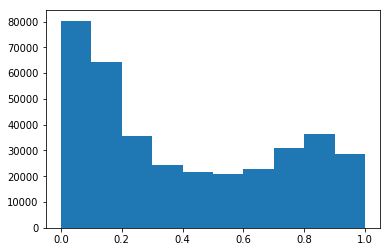

In [ ]:
## 预测结果，并对结果统计信息进行可视化。压缩保存当前的模型、代码等。
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
else:
    os.system('rm -rf %s/*.*'%OUTPUT_PATH)
Yp = predict(model, test_dataset)
if USE_POST_PROCESS:
    Yp = [(1-np.cos(X*np.pi))/2 for X in Yp]
for data_i, (data, Q) in enumerate(zip(test_dataset, Yp)):
    save_path = os.path.join(OUTPUT_PATH, '%d.predict.txt'%(data_i+1))
    with open(save_path, 'w') as f:
        for p in Q:
            f.write('%.8f\n'%p)
# if os.path.exists('predict.files.zip'):
os.system('rm -rf *.zip')
os.system('zip -qr predict.files.zip %s && rm -rf %s'%(OUTPUT_PATH, OUTPUT_PATH))
os.system('cd Models && zip -qr %s.zip %s vdl_log && mv %s.zip ../'%(USE_MODEL, USE_MODEL, USE_MODEL))
os.system('zip -qr source_all.zip *.py *.ipynb work/ %s.zip work/'%USE_MODEL)
plt.hist(np.concatenate(Yp))